In [1]:
import numpy as np
import pickle
import cv2
import tensorflow
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [88]:
# collecting dataset

# not required - api credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# download dataset
!kaggle datasets download -d emmarex/plantdisease --force

# unzip
import zipfile
zip_ref = zipfile.ZipFile('/content/plantdisease.zip', 'r')
zip_ref.extractall('/content/input')
zip_ref.close()

# details about the dataset
image_dir = "/content/input/PlantVillage"

folder_names = listdir(image_dir)
res = []
for folder_name in folder_names:
    num_images = len([f for f in os.listdir(os.path.join(image_dir, folder_name))
                      if os.path.isfile(os.path.join(image_dir, folder_name, f))])
    print(f"{folder_name} -> {num_images}")
    res.append(num_images)
min_no_of_images = min(res)
max_no_of_images = max(res)
avg_no_of_images = sum(res)//len(res)
print("No of images per folder:","min:",min_no_of_images, "max:", max_no_of_images,"avg:", avg_no_of_images)
print("total:", sum(res))

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 652M/658M [00:36<00:00, 20.3MB/s]
100% 658M/658M [00:36<00:00, 18.7MB/s]
Potato___healthy -> 152
Pepper__bell___healthy -> 1478
Tomato_Leaf_Mold -> 952
Tomato_Spider_mites_Two_spotted_spider_mite -> 1676
Tomato_Early_blight -> 1000
Tomato__Tomato_YellowLeaf__Curl_Virus -> 3209
Potato___Late_blight -> 1000
Tomato_Late_blight -> 1909
Tomato_healthy -> 1591
Potato___Early_blight -> 1000
Tomato__Target_Spot -> 1404
Tomato_Bacterial_spot -> 2127
Tomato__Tomato_mosaic_virus -> 373
Pepper__bell___Bacterial_spot -> 997
Tomato_Septoria_leaf_spot -> 1771
No of images per folder: min: 152 max: 3209 avg: 1375
total: 20639


In [87]:
# variables
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/input/plantvillage'
width=256
height=256
depth=3


# funtion to convert image to numpy array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None


image_list, label_list = [], []
try:
    print("Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print("Processing: ",plant_disease_folder, "->", end="")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            # how many photos to select from every folder
            # num_of_photos = int(min(len(plant_disease_image_list), avg_no_of_images//5))
            num_of_photos = 200
            print("photos selected:", min(num_of_photos,len(plant_disease_image_list)))
            # google collab can't process 250 each

            for image in plant_disease_image_list[:num_of_photos]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)

    image_size = len(image_list)
    print("Image loading completed: ",image_size)
except Exception as e:
    print(f"Error : {e}")

Loading images ...
Processing:  Potato___healthy ->photos selected: 152
Processing:  Pepper__bell___healthy ->photos selected: 200
Processing:  Tomato_Leaf_Mold ->photos selected: 200
Processing:  Tomato_Spider_mites_Two_spotted_spider_mite ->photos selected: 200
Processing:  Tomato_Early_blight ->photos selected: 200
Processing:  Tomato__Tomato_YellowLeaf__Curl_Virus ->photos selected: 200
Processing:  Potato___Late_blight ->photos selected: 200
Processing:  Tomato_Late_blight ->photos selected: 200
Processing:  Tomato_healthy ->photos selected: 200
Processing:  Potato___Early_blight ->photos selected: 200
Processing:  Tomato__Target_Spot ->photos selected: 200
Processing:  Tomato_Bacterial_spot ->photos selected: 200
Processing:  Tomato__Tomato_mosaic_virus ->photos selected: 200
Processing:  Pepper__bell___Bacterial_spot ->photos selected: 200
Processing:  Tomato_Septoria_leaf_spot ->photos selected: 200
Image loading completed:  2952


In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
#print(label_binarizer.classes_)

np_image_list = np.array(image_list, dtype=np.float16) / 225.0
# print(np_image_list)

print("Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

Spliting data to train, test


In [6]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [7]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Replace 'n_classes' with the number of output classes
model.add(Dense(n_classes))
model.add(Activation("softmax"))


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 85, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 85, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 85, 85, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 85, 85, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 85, 85, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 85, 85, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 85, 85, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 85, 85, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 42, 42, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 42, 42, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 42, 42, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 42, 42, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 42, 42, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 42, 42, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 58,102,671 (221.64 MB)

 Trainable params: 58,099,791 (221.63 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [8]:
opt = Adam(learning_rate=INIT_LR)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

[INFO] training network...
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 69s 673ms/step - accuracy: 0.1661 - loss: 0.7779 - val_accuracy: 0.0778 - val_loss: 0.7522
Epoch 2/25
 1/73 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.3125 - loss: 0.3704

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3125 - loss: 0.3704 - val_accuracy: 0.0812 - val_loss: 0.8129
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 37s 474ms/step - accuracy: 0.2881 - loss: 0.2824 - val_accuracy: 0.0795 - val_loss: 0.6440
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6250 - loss: 0.1774 - val_accuracy: 0.0795 - val_loss: 0.6300
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 513ms/step - accuracy: 0.5309 - loss: 0.1690 - val_accuracy: 0.1184 - val_loss: 0.7960
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5625 - loss: 0.1702 - val_accuracy: 0.1168 - val_loss: 0.8184
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 36s 438ms/step - accuracy: 0.6483 - loss: 0.1327 - val_accuracy: 0.0728 - val_loss: 0.7212
Epoch 8/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5938 - loss: 0.1600 - val_accuracy: 0.0694 - val_loss: 0.7294
Epoch 9/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 429ms/step - accuracy: 0.6805 - loss: 0.1191 - val_accuracy: 0.1912 - val_los

{'verbose': 1, 'epochs': 25, 'steps': 73} dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


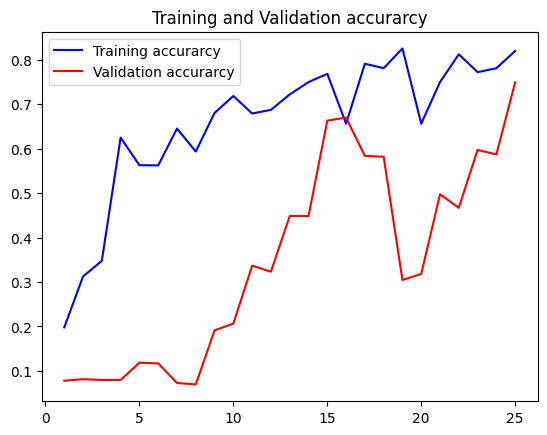

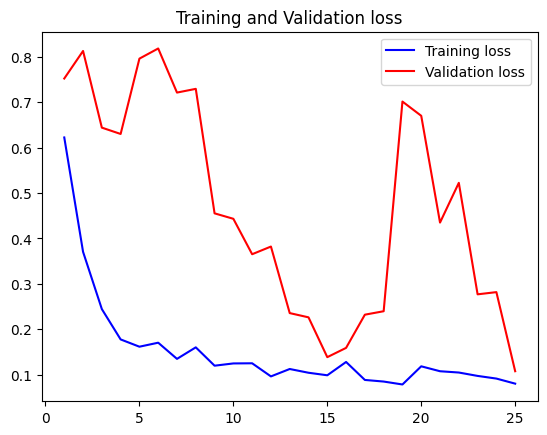

Calculating model accuracy
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7443 - loss: 0.1113
Test Accuracy: 74.9576985836029


In [9]:
print(history.params,history.history.keys())

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

print("Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

In [68]:
print("[INFO] Saving model...")
# pickle.dump(model,open('cnn_model.pkl', 'wb'))
model.save("ldd_cnn_model.keras")

loaded_model = load_model("ldd_cnn_model.keras")

[INFO] Saving model...


In [18]:
!zip -r '/content/my_model.zip' '/content/ldd_cnn_model.keras'

updating: content/ldd_cnn_model.keras (deflated 8%)


['Potato___healthy', 'Pepper__bell___healthy', 'Tomato_Leaf_Mold', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Potato___Late_blight', 'Tomato_Late_blight', 'Tomato_healthy', 'Potato___Early_blight', 'Tomato__Target_Spot', 'Tomato_Bacterial_spot', 'Tomato__Tomato_mosaic_virus', 'Pepper__bell___Bacterial_spot', 'Tomato_Septoria_leaf_spot']



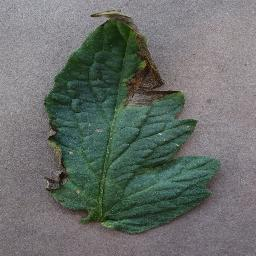

selected: Tomato_Early_blight/4aa63e45-c531-40e2-86ca-a788e74d4f18___RS_Erly.B 7549.JPG


In [83]:
image_dir="/content/input/PlantVillage"

disease_folder_names = listdir(image_dir)
print(disease_folder_names)

# select a folder
disease_folder_name = disease_folder_names[4]

images = listdir(f"{image_dir}/{disease_folder_name}")

# select image
image_location = f"{image_dir}/{disease_folder_name}/{images[0]}"
im=convert_image_to_array(image_location)

from IPython.display import Image
display(Image(image_location))
print("selected:" ,image_location[28:])

np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(im, axis=0)

In [85]:
result = loaded_model.predict(npp_image)
print(result)

itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])
print(label_binarizer.classes_[itemindex[1][0]]==disease_folder_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
probability:1.0
Tomato_Early_blight
True
